# Projeto PAMAP2

O objetivo do projeto é desenvolver modelos que permitam classificar quanto à atividade dados com a mesma estrutura aos obtidos no dataset de referência ( [PAMAP2](https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring) ). Apenas serão consideradas as atividades 4, 5, 6, 7 e 24 (5 atividades de intensidade do membro inferior (?)). Estas correspondem, respetivamente, a 'Walking', 'Running', 'Cycling', 'Nordic Walking', e 'Rope Jumping'.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import sklearn as sk
from sklearn.model_selection import train_test_split

In [2]:
dataCol = pd.read_csv('data_df.csv')
dataCol.shape

(1942872, 43)

In [3]:
dataCol.head()

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
0,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1
1,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1
2,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1
3,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1


In [3]:
#Para experimentar o codigo: sample de 100k. Correr com os dados todos no pc
dataCol= dataCol.sample(n= 200000, random_state= 1)

In [4]:
act_n= [4, 5, 6, 7, 24]
act_data= dataCol.loc[dataCol['activityID'].isin(act_n)]
act_data['activityID'].value_counts()

4     238761
7     188107
6     164600
5      98199
24     49360
Name: activityID, dtype: int64

<Axes: xlabel='activityID'>

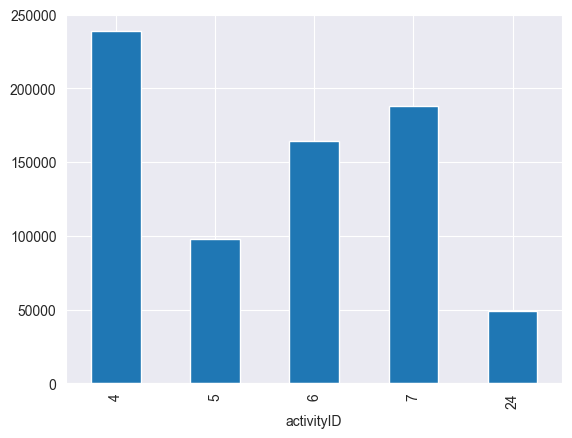

In [5]:
act_data.groupby('activityID').size().plot(kind='bar',
                                       y = 'activityID',
                                       label = "Type",)

Como as diferentes classes têm counts bastante diferentes irão ser aplicadas técnicas que permitam equilibrar as diferentes classes do dataset

## Downsampling

In [6]:
from sklearn.utils import resample

act_downsample= []
for i in range(len(act_n)):
    act_downsample.append(resample(act_data.loc[act_data['activityID']== act_n[i]],
                 replace=True,
                 n_samples= min(act_data['activityID'].value_counts()),
                 random_state=1))

In [7]:
data_downsampled_df= pd.concat(act_downsample).drop(['timestamp', 'subject_id'], axis= 1)
data_downsampled_df.reset_index(inplace= True)
data_downsampled_df.drop(['index'], axis=1, inplace= True)

In [8]:
train_val_df= data_downsampled_df.sample(frac= 0.8, random_state= 1)
test_df= data_downsampled_df.drop(train_val_df.index)

train_val_df.shape[0]+test_df.shape[0]== data_downsampled_df.shape[0] #check if the split has lost any rows. If true no rows were lost. If False some rows were lost in the split

True

In [9]:
train_val_df.shape, test_df.shape

((197440, 41), (49360, 41))

In [10]:
train_val_df.to_csv('train_val_df_downsampled.csv', index=False)
test_df.to_csv('test_df_downsampled.csv', index=False)

In [28]:
train_val_df= pd.read_csv('train_val_df_downsampled.csv')
test_df= pd.read_csv('test_df_downsampled.csv')

Separar as features e as labels para as dfs de treino/validação e teste

In [11]:
features_tv_df= train_val_df.drop(['activityID'], axis= 1, inplace=False)

features_ts_df= test_df.drop(['activityID'], axis= 1, inplace=False)
true_labels_ts= test_df['activityID']
features_tv_df.shape, features_ts_df.shape, true_labels_ts.shape

((197440, 40), (49360, 40), (49360,))

Para utilizar a loss function 'Categorical Crossentropy' é necessário que as target labels sejam dadas no formato one-hot

In [12]:
from sklearn.preprocessing import LabelBinarizer

targets_onehot_tv = LabelBinarizer().fit_transform(train_val_df.activityID)
targets_onehot_tv.shape

(197440, 5)

Dividir o Train/Validation dataset

In [13]:
x_train, x_val, y_train, y_val = train_test_split(features_tv_df, targets_onehot_tv, test_size=0.2, random_state=1)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((157952, 40), (39488, 40), (157952, 5), (39488, 5))

Vão ser utilizados modelos com arquiteturas iguais aos do projeto A

| **Scaler/Modelo** 	| **Simples/GG** 	 | **Grande** 	|
|-------------------	|------------------|------------	|
| **Nada**          	| NS          	    | NG         	|
| **MinMax**        	| MS        	      | MG         	|

Aplicar Min Max Scaling aos dados

In [14]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#apply scaling to all columns except subject and activity
scalerM = MinMaxScaler()
x_train_s = x_train.copy()
x_val_s = x_val.copy()
x_test_s= features_ts_df.copy()

x_train_s = scalerM.fit_transform(x_train_s)
x_val_s = scalerM.transform(x_val_s)
x_test_s= scalerM.transform(x_test_s)

pd.DataFrame(x_train_s).describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000,...,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000,157952.000000
mean,0.467912,0.615714,0.649766,0.363271,0.400101,0.511302,0.533333,0.547296,0.542302,0.439985,...,0.499462,0.579208,0.511531,0.561075,0.653244,0.569460,0.429039,0.632783,0.596691,0.530054
std,0.203436,0.213962,0.050208,0.047436,0.020348,0.072367,0.085960,0.044708,0.038044,0.040209,...,0.019747,0.069777,0.084065,0.046023,0.041783,0.029035,0.104635,0.064036,0.106874,0.069003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.330645,0.478261,0.623724,0.345562,0.391355,0.474190,0.500196,0.528037,0.528553,0.423854,...,0.494336,0.544164,0.482758,0.546567,0.632347,0.559035,0.366073,0.602236,0.516813,0.484051
50%,0.403226,0.590062,0.649539,0.359454,0.400301,0.511316,0.526614,0.548142,0.541123,0.437077,...,0.500442,0.569296,0.503600,0.564073,0.652027,0.571882,0.421629,0.631164,0.588464,0.534056
75%,0.629032,0.801242,0.679510,0.376221,0.412005,0.554198,0.558939,0.574100,0.555184,0.454226,...,0.505975,0.609369,0.535690,0.580137,0.672467,0.583865,0.477081,0.660381,0.679477,0.583331
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
n_features = features_tv_df.shape[1]
n_classes = targets_onehot_tv.shape[1]
n_features, n_classes

(40, 5)

In [16]:
pd.DataFrame(x_test_s).to_csv('scaled_test_features_downsampled.csv', index= False)
true_labels_ts.to_csv('true_labels_ts_downsampled.csv', index= False)
features_ts_df.to_csv('features_ts_df_downsampled.csv', index= False)

In [17]:
from tensorflow import keras
tf.keras.backend.clear_session()

In [18]:
def compile_fit(model, x_train, y_train, x_val, y_val, epochs):
    model.compile(optimizer= 'adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['categorical_accuracy'])
    history = model.fit(x_train, y_train, batch_size= 512, epochs= epochs, validation_data= (x_val, y_val))

    return history

In [19]:
model_history= {}

In [20]:
NS = tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')])
model_history['NS']= compile_fit(NS, x_train, y_train, x_val, y_val, 15)

Epoch 1/15
309/309 [==============================] - 3s 6ms/step - loss: 0.6957 - categorical_accuracy: 0.8211 - val_loss: 0.2225 - val_categorical_accuracy: 0.9306
Epoch 2/15
309/309 [==============================] - 2s 5ms/step - loss: 0.1572 - categorical_accuracy: 0.9503 - val_loss: 0.1379 - val_categorical_accuracy: 0.9558
Epoch 3/15
309/309 [==============================] - 2s 6ms/step - loss: 0.1032 - categorical_accuracy: 0.9670 - val_loss: 0.0907 - val_categorical_accuracy: 0.9718
Epoch 4/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0808 - categorical_accuracy: 0.9743 - val_loss: 0.0737 - val_categorical_accuracy: 0.9765
Epoch 5/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0656 - categorical_accuracy: 0.9786 - val_loss: 0.0644 - val_categorical_accuracy: 0.9787
Epoch 6/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0559 - categorical_accuracy: 0.9819 - val_loss: 0.0575 - val_categorical_accuracy: 0.9819
Epoc

In [21]:
NG= tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation= 'softmax')
])
model_history['NG']= compile_fit(NG, x_train, y_train, x_val, y_val, 15)

Epoch 1/15
309/309 [==============================] - 3s 8ms/step - loss: 0.2930 - categorical_accuracy: 0.9103 - val_loss: 0.0630 - val_categorical_accuracy: 0.9796
Epoch 2/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0518 - categorical_accuracy: 0.9828 - val_loss: 0.0427 - val_categorical_accuracy: 0.9864
Epoch 3/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0367 - categorical_accuracy: 0.9876 - val_loss: 0.0303 - val_categorical_accuracy: 0.9902
Epoch 4/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0282 - categorical_accuracy: 0.9905 - val_loss: 0.0234 - val_categorical_accuracy: 0.9927
Epoch 5/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0249 - categorical_accuracy: 0.9914 - val_loss: 0.0353 - val_categorical_accuracy: 0.9877
Epoch 6/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0197 - categorical_accuracy: 0.9931 - val_loss: 0.0298 - val_categorical_accuracy: 0.9895
Epoc

In [22]:
MG = tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')])
model_history['MG']= compile_fit(MG, x_train_s, y_train, x_val_s, y_val, 15)

Epoch 1/15
309/309 [==============================] - 3s 7ms/step - loss: 0.4716 - categorical_accuracy: 0.8230 - val_loss: 0.2067 - val_categorical_accuracy: 0.9298
Epoch 2/15
309/309 [==============================] - 2s 7ms/step - loss: 0.1151 - categorical_accuracy: 0.9633 - val_loss: 0.1112 - val_categorical_accuracy: 0.9607
Epoch 3/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0852 - categorical_accuracy: 0.9710 - val_loss: 0.1005 - val_categorical_accuracy: 0.9706
Epoch 4/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0338 - categorical_accuracy: 0.9892 - val_loss: 0.0282 - val_categorical_accuracy: 0.9903
Epoch 5/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0201 - categorical_accuracy: 0.9937 - val_loss: 0.0336 - val_categorical_accuracy: 0.9882
Epoch 6/15
309/309 [==============================] - 2s 7ms/step - loss: 0.0173 - categorical_accuracy: 0.9945 - val_loss: 0.0134 - val_categorical_accuracy: 0.9961
Epoc

In [23]:
MS= tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation= 'softmax')
])
model_history['MS']= compile_fit(MS, x_train_s, y_train, x_val_s, y_val, 15)

Epoch 1/15
309/309 [==============================] - 3s 8ms/step - loss: 0.8575 - categorical_accuracy: 0.6568 - val_loss: 0.5387 - val_categorical_accuracy: 0.7956
Epoch 2/15
309/309 [==============================] - 2s 7ms/step - loss: 0.4540 - categorical_accuracy: 0.8361 - val_loss: 0.4153 - val_categorical_accuracy: 0.8546
Epoch 3/15
309/309 [==============================] - 2s 7ms/step - loss: 0.3367 - categorical_accuracy: 0.8851 - val_loss: 0.3128 - val_categorical_accuracy: 0.8978
Epoch 4/15
309/309 [==============================] - 2s 7ms/step - loss: 0.2664 - categorical_accuracy: 0.9118 - val_loss: 0.2510 - val_categorical_accuracy: 0.9186
Epoch 5/15
309/309 [==============================] - 2s 7ms/step - loss: 0.2188 - categorical_accuracy: 0.9295 - val_loss: 0.2284 - val_categorical_accuracy: 0.9282
Epoch 6/15
309/309 [==============================] - 2s 7ms/step - loss: 0.1864 - categorical_accuracy: 0.9401 - val_loss: 0.1790 - val_categorical_accuracy: 0.9415
Epoc

In [24]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display

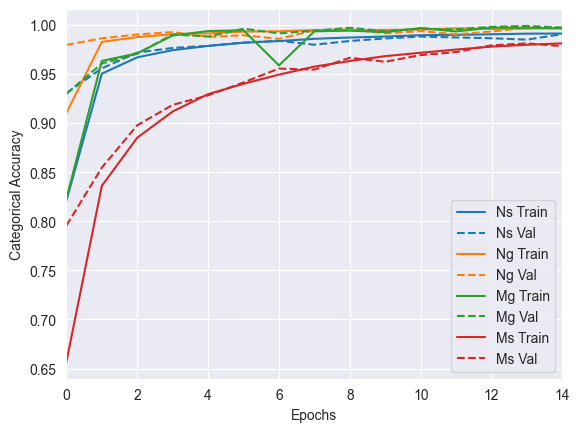

In [25]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'categorical_accuracy')
plotter.plot(model_history)


In [26]:
NS.save('Models Projeto B/NS_ds')
NG.save('Models Projeto B/NG_ds')
MG.save('Models Projeto B/MG_ds')
MS.save('Models Projeto B/MS_ds')

INFO:tensorflow:Assets written to: Models Projeto B/NS_ds\assets
INFO:tensorflow:Assets written to: Models Projeto B/NG_ds\assets
INFO:tensorflow:Assets written to: Models Projeto B/MG_ds\assets
INFO:tensorflow:Assets written to: Models Projeto B/MS_ds\assets
